## Template Matching Demo
Original notebook: Sentil Periaswami
Edits: Vasha DuTell

## Classical template matching in pixel space

Here we use cv2 built-ins like cv2.matchTemplate

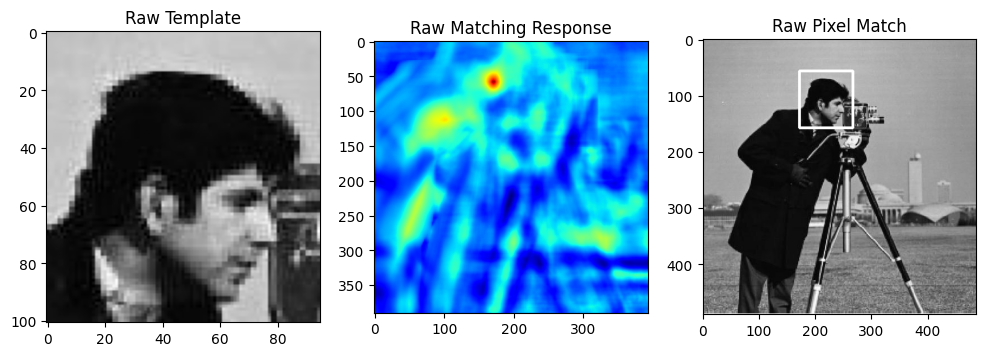

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Load images in grayscale (Original Raw Pixels)
img_large_raw = cv2.imread('imgs/cameraman.jpg', 0)
img_template_raw = cv2.imread('imgs/head.jpg', 0)

# 1. Use OpenCV's normalized matching
# TM_CCOEFF_NORMED subtracts the mean and divides by the standard deviation
raw_response = cv2.matchTemplate(img_large_raw, img_template_raw, cv2.TM_CCOEFF_NORMED)

# 2. Find the best match (the peak)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(raw_response)

# 3. Draw the result
h, w = img_template_raw.shape
# Note: For drawing boxes on grayscale images, use a single value (e.g., 255 for white)
img_display = cv2.imread('imgs/cameraman.jpg', 0) 
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)
cv2.rectangle(img_display, top_left, bottom_right, 255, 3)
cv2.rectangle(img_display, top_left, bottom_right, (255, 0, 0), 3) # Blue box for raw match

# 5. Visualization
plt.figure(figsize=(12, 6))
plt.subplot(131), plt.imshow(img_template_raw, cmap='gray'), plt.title('Raw Template')
plt.subplot(132), plt.imshow(raw_response, cmap='jet'), plt.title('Raw Matching Response')
#plt.colorbar()
plt.subplot(133), plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)), plt.title('Raw Pixel Match')
plt.show()

## Template Matching in Pixel Feature Space
This method gives the same answer, but note the higher signal to noise ratio in the matching response.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


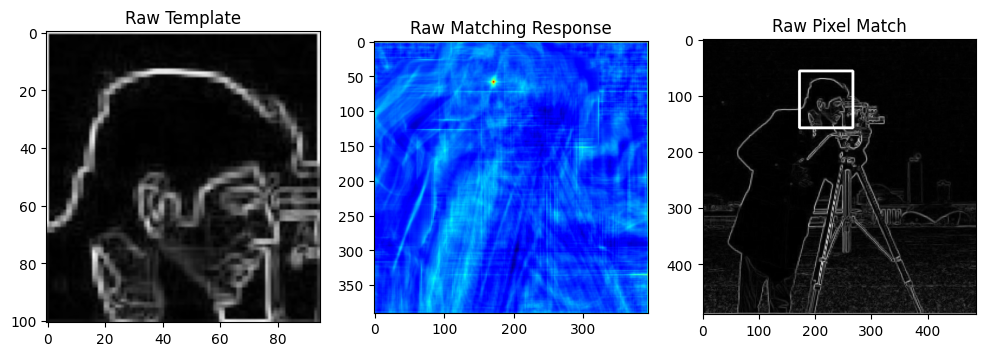

In [2]:
from scipy.signal import convolve2d

#function to get edge image
def get_edge_image(img):
    kernel_x = np.array([[-1, 0, 1],
                         [-1, 0, 1],
                         [-1, 0, 1]])
    kernel_y = np.array([[-1, -1, -1],
                         [0, 0, 0],
                         [1, 1, 1]])
    img_x = convolve2d(img, kernel_x, mode='same', boundary='fill', fillvalue=0)
    img_y = convolve2d(img, kernel_y, mode='same', boundary='fill', fillvalue=0)

    img_out = np.sqrt(img_x * img_x + img_y*img_y)
    return img_out

# 0. Convert Tempalte and Image to Edge Images
img_large_edges = get_edge_image(img_large_raw).astype(np.float32)
img_template_edges = get_edge_image(img_template_raw).astype(np.float32)

# 1. Use OpenCV's normalized matching
# TM_CCOEFF_NORMED subtracts the mean and divides by the standard deviation
raw_response = cv2.matchTemplate(img_large_edges, img_template_edges, cv2.TM_CCOEFF_NORMED)

# 2. Find the best match (the peak)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(raw_response)

# 3. Draw the result
h, w = img_template_raw.shape
# Note: For drawing boxes on grayscale images, use a single value (e.g., 255 for white)
#img_display = cv2.imread('imgs/cameraman.jpg', 0) 
img_display = img_large_edges / np.max(img_large_edges)


top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)
cv2.rectangle(img_display, top_left, bottom_right, 255, 3)
cv2.rectangle(img_display, top_left, bottom_right, (255, 0, 0), 3) # Blue box for raw match

# 5. Visualization
plt.figure(figsize=(12, 6))
plt.subplot(131), plt.imshow(img_template_edges, cmap='gray'), plt.title('Raw Template')
plt.subplot(132), plt.imshow(raw_response, cmap='jet'), plt.title('Raw Matching Response')
#plt.colorbar()
plt.subplot(133), plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)), plt.title('Raw Pixel Match')
plt.show()

## Fourier-based template Matching with custom functions

Here we build our own functions for conlution and fourier-based template matching

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import timeit

def response_convolution(img_large,img_template):
    img_template = np.flipud(np.fliplr(img_template))
    img_response = convolve2d(img_large, img_template, mode='same', boundary='fill', fillvalue=0)
    return img_response
    
def response_fft(img_large,img_template):

    (h,w) = img_large.shape
    img_large = pad_to(img_large, h*2, w*2)
    img_template = pad_to(img_template, h*2, w*2)
    
    template_fft = np.fft.fft2(img_template)
    image_fft    = np.fft.fft2(img_large)
    
    # Perform element-wise multiplication
    #multiplying by complex conjugate returns magnitude 
    correlation_result_fft = image_fft * np.conj(template_fft)
    
    # Perform inverse FFT to get correlation result in spatial domain
    correlation_result = np.fft.ifft2(correlation_result_fft)
    correlation_result = np.fft.fftshift(correlation_result).real

    return   crop_center(correlation_result,w,h)
    
def pad_to(array, xx, yy):

    h = array.shape[0]
    w = array.shape[1]

    a = (xx - h) // 2
    aa = xx - a - h

    b = (yy - w) // 2
    bb = yy - b - w

    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]


In [4]:
import os
#os.chdir(r"C:\github\template")

#read in our images
img_large = cv2.imread('imgs/cameraman.jpg')
img_template = cv2.imread('imgs/head.jpg')

# Convert images to grayscale
img_template = cv2.cvtColor(img_template, cv2.COLOR_BGR2GRAY) 
img_large = cv2.cvtColor(img_large, cv2.COLOR_BGR2GRAY)
img_large = pad_to(img_large, 512, 512)
print(img_large.shape)

img_large = get_edge_image(img_large)
img_template = get_edge_image(img_template)

(512, 512)


## Template Matching with Convolution

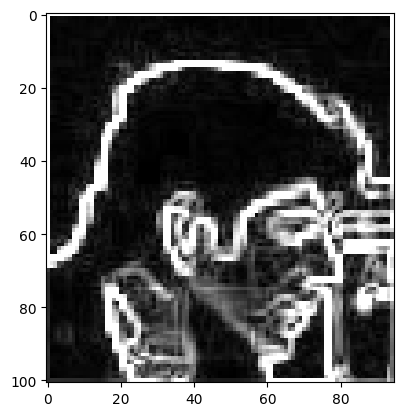

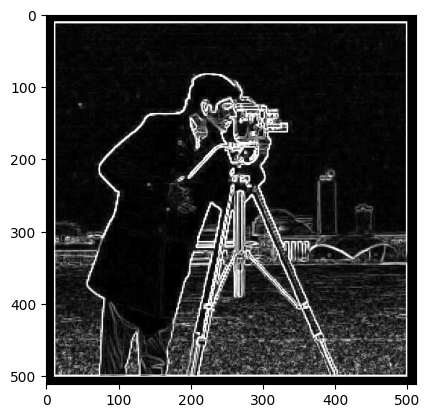

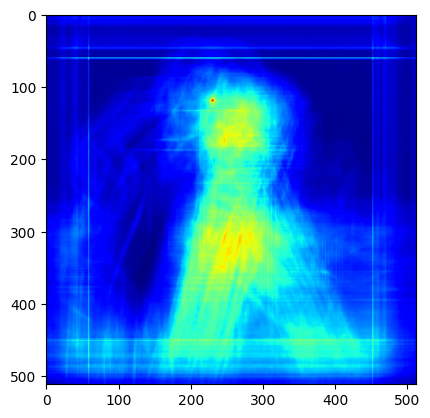

In [5]:
# Perform template matching
img_response = response_convolution(img_large,img_template)

plt.imshow(img_template, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.figure()
plt.imshow(img_large, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.figure()
plt.imshow(img_response,  cmap='jet')
plt.show()

## FFT Version

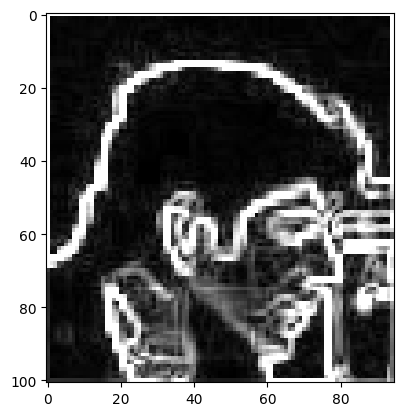

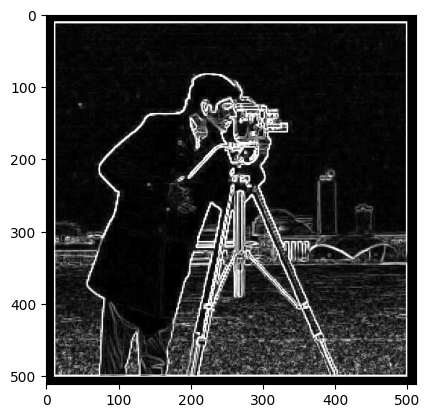

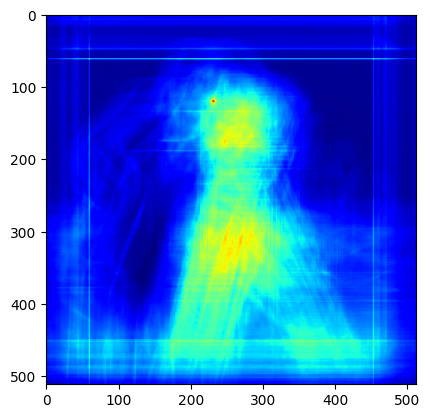

In [6]:
## FFT version (increases speed)
img_response = response_fft(img_large,img_template)


plt.imshow(img_template, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.figure()
plt.imshow(img_large, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.figure()
plt.imshow(img_response,  cmap='jet')


plt.show()